# Importar bibliotecas

In [6]:
import sys
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
load_dotenv()
sys.path.append(os.getenv("PYTHONPATH"))

from src.url.utils.constants import URL_PROCESS_DATASET_PATH

# Cargar datos

In [7]:
df = pd.read_csv(URL_PROCESS_DATASET_PATH)

In [8]:
X = df.iloc[:, 1:].drop('result', axis=1)
y = df['result']

In [9]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Entrenar modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Support Vector Machine': SVC(probability=True)  # Necesario para calcular AUC
}

In [19]:
# Evaluar modelos
results = {}
confusion_matrices = {}
roc_curves = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr') if y_proba is not None else None
    
    results[model_name] = [accuracy, precision, recall, f1, auc]
    
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    if y_proba is not None and len(np.unique(y)) == 2:  # Calcular ROC solo para problemas binarios
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_curves[model_name] = (fpr, tpr)
    
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrices[model_name])
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("-" * 60)

Model: Logistic Regression
Confusion Matrix:
[[ 285    0  501]
 [   0    0    1]
 [ 146    0 2996]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.36      0.47       786
           0       1.00      0.00      0.00         1
           1       0.86      0.95      0.90      3142

    accuracy                           0.84      3929
   macro avg       0.84      0.44      0.46      3929
weighted avg       0.82      0.84      0.82      3929

------------------------------------------------------------
Model: Decision Tree
Confusion Matrix:
[[ 492    0  294]
 [   0    0    1]
 [ 258    3 2881]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.63      0.64       786
           0       0.00      0.00      0.00         1
           1       0.91      0.92      0.91      3142

    accuracy                           0.86      3929
   macro avg       0.52      0.51      0.52   

In [20]:
# Crear DataFrame con los resultados
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']).T
print(results_df)

                        Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression     0.835073   0.817469  0.835073  0.815349  0.678668
Decision Tree           0.858488   0.856649  0.858488  0.857477  0.745453
Random Forest           0.868669   0.863543  0.868669  0.865240  0.758851
Support Vector Machine  0.851107   0.838741  0.851107  0.835475  0.677247


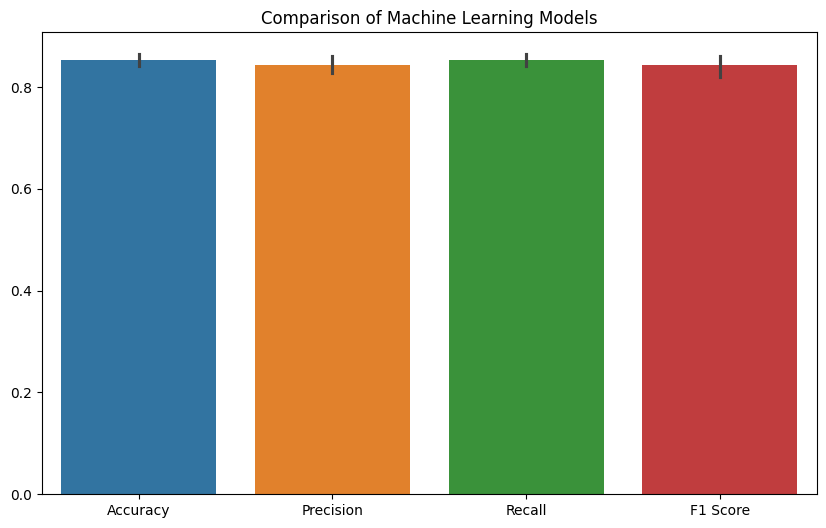

In [21]:
# Visualizar resultados
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.drop(columns='AUC'))
plt.title('Comparison of Machine Learning Models')
plt.show()

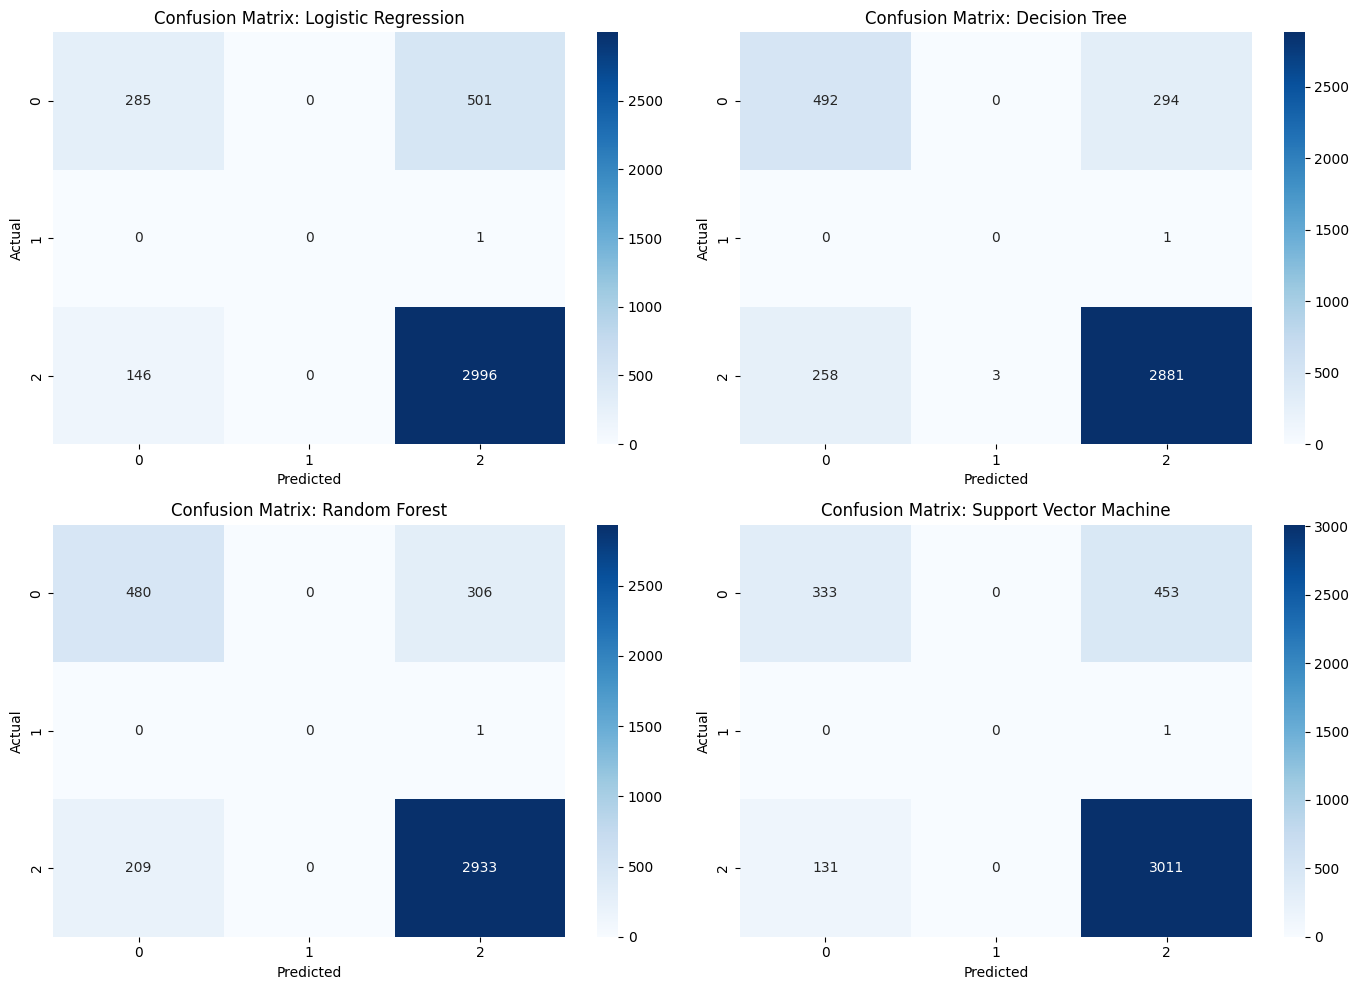

In [22]:
# Visualizar las matrices de confusión
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [23]:
# Visualizar las curvas ROC (solo para clasificación binaria)
if len(np.unique(y)) == 2:
    plt.figure(figsize=(10, 6))
    for model_name, (fpr, tpr) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results[model_name][-1]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()